<a href="https://colab.research.google.com/github/CallMeL/OML-hw/blob/master/quasi_newton_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise sheet 6

**Please turn in your exercises by Monday, December 16th.**

## Task 1: Correction pairs

Let $f \in \mathcal{S}_{\mu, L}$

Prove $y_t^\top s_t > 0 $ if $x_t \neq x_{t-1}$.

Provide another function $f\colon \mathbb{R} \to \mathbb{R}$ such that $f'(0) = 0$ and $f'(1) = -1/4$ where $y_t^\top s_t > 0$ does not hold.



## Task 2: DFP update rule

Consider the DFP method.

Use the Sherman-Morrison-Woodbury formula on the hessian $B_t$ to derive the inverse of the hessian $H_t$.

## Task 3: BFGS update rule

Consider the BFGS method.

Use the Sherman-Morrison-Woodbury formula on the inverse of the hessian $H_t$ to derive the hessian $B_t$.

## Task 4: Convergence

Prove the convergence of the DFP and BFGS methods.

## Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def contour_map(f, xb=(-1, 1), yb=(-1, 1), ax=None):
    if ax is None:
        ax = plt
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx, ny)
    ax.contour(xv, yv, zv, 15)


def surface_plot(f, xb=(-1, 1), yb=(-1, 1)):
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx, ny)
    ax.plot_surface(xv, yv, zv, cmap=cm.coolwarm)
    return fig, ax

In [3]:
def backtracking_line_search(x, d, f, g, alpha=0.3, beta=0.8):
    step_size = 1.0
    while f(x + step_size * d) > f(x) + alpha * step_size * g(x).dot(d):
        step_size *= beta
    return step_size


def backtracking_line_search_nag(x, d, f, g, alpha=1.0, beta=0.8):
    t = 1
    while f(x + t * d) > f(x) + alpha * t * np.dot(g(x), d) + t / 2 * np.dot(d, d):
        t *= beta
    return t


In [4]:
def gradient_descent_path(x0, f, g, max_iter=100):
    xs = [x0]
    for _ in range(max_iter):
        step = backtracking_line_search(x0, -g(x0), f, g)
        x0 = x0 - step * g(x0)
        xs.append(x0)
    return xs


def heavy_ball_path(x0, f, g, max_iter=100):
    xs = [x0]
    x_old = x0
    for i in range(1, max_iter + 1):
        d = -g(x0) + (i - 1) / (i + 1) * (x0 - x_old)
        x_old = x0
        t = backtracking_line_search_nag(x0, d, f, g)
        x0 = x0 + t * d
        xs.append(x0)
    return xs


def nag_path(x0, f, g, max_iter=100):
    xs = [x0]
    x_old = x0
    for i in range(1, max_iter + 1, 1):
        y = x0 + (i - 1) / (i + 2) * (x0 - x_old)
        x_old = x0
        t = backtracking_line_search_nag(y, -g(y), f, g)
        x0 = y - t * g(y)
        xs.append(x0)
    return np.array(xs)


def newtons_method_path(x0, f, g, h, max_iter=100):
    xs = [x0]
    for _ in range(max_iter):
        p = np.linalg.solve(h(x0), g(x0))
        step = backtracking_line_search(x0, -p, f, g)
        x0 = x0 - step * p
        xs.append(x0)
    return xs

In [5]:
EXA = np.array([[30.0, 15], [-20, 25]]) / 20

EXAMPLES = [
    (
        lambda x: x.T @ EXA @ x + 1,
        lambda x: (EXA + EXA.T) @ x,
        lambda x: (EXA + EXA.T),
        0.5 * np.ones(2),
        (-1.0, 1.0),
        (-1.0, 1.0),
    ),
    (
        lambda x: (x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]),
        lambda x: np.array([2 * x[0] + 4, 60 * x[1]]),
        lambda x: np.array([[2, 0], [0, 60]]),
        np.array([2.0, 3.0]),
        (-2.5, 2.5),
        (-1.5, 3.5),
    ),
    (
        lambda x: np.linalg.norm(np.sin(x * 3)) ** 2,
        lambda x: 6 * np.sin(x * 3) * np.cos(x * 3),
        lambda x: 18 * np.diag(2 * np.cos(3 * x) ** 2 - 1),
        np.array([0.2, 0.15]),
        (-0.5, 0.5),
        (-0.5, 0.5),
    ),
]


def run_examples_dfp():
    for f, g, h, x0, xb, yb in EXAMPLES:
        xs2 = dfp_path(x0, f, g)
        xs2 = np.array(xs2)

        xs = gradient_descent_path(x0, f, g)
        xs = np.array(xs)

        contour_map(f, xb=xb, yb=yb)
        plt.plot(xs2[:, 0], xs2[:, 1], ".--k", label="newtons method")
        plt.plot(
            xs[:, 0], xs[:, 1], ".--", color="gray", alpha=0.5, label="gradient descent"
        )
        plt.legend()
        plt.show()


def run_examples_bfgs():
    for f, g, h, x0, xb, yb in EXAMPLES:
        xs2 = bfgs_path(x0, f, g)
        xs2 = np.array(xs2)

        xs = gradient_descent_path(x0, f, g)
        xs = np.array(xs)

        contour_map(f, xb=xb, yb=yb)
        plt.plot(xs2[:, 0], xs2[:, 1], ".--k", label="newtons method")
        plt.plot(
            xs[:, 0], xs[:, 1], ".--", color="gray", alpha=0.5, label="gradient descent"
        )
        plt.legend()
        plt.show()

## Task 5: DFP method

Implement the DFP method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `dfp_path` should return a list of vectors on the path to the minimum.

In [7]:
def dfp_path(x0, f, g, max_iter=100):
    tol = 1e-8
    n = len(x0)
    Hk = np.eye(n)
    g_old = g(x0)
    x_old = x0
    xs = [x0]

    for _ in range(max_iter):
        d = -Hk.dot(g_old)
        step = backtracking_line_search(x_old, d, f, g)
        x_new = x_old + step * d

        sk = x_new - x_old
        g_new = g(x_new)
        yk = g_new - g_old

        if sk.dot(yk) > tol:
            Hkyk = Hk.dot(yk)
            Hk -= np.outer(Hkyk, Hkyk) / Hkyk.dot(yk)
            Hk += np.outer(sk, sk) / sk.dot(yk)

        x_old, g_old = x_new, g_new
        xs.append(x_new)

    return xs

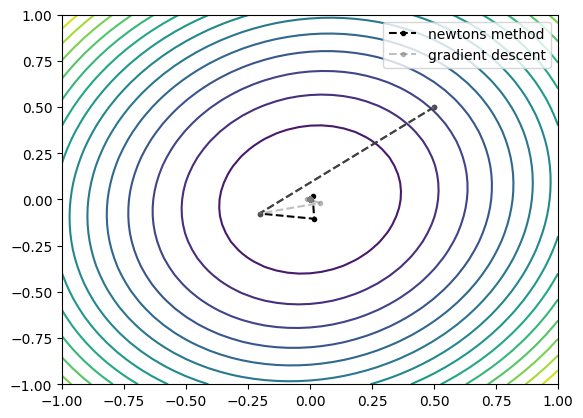

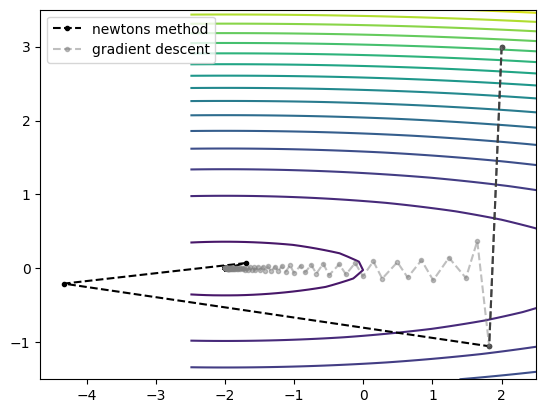

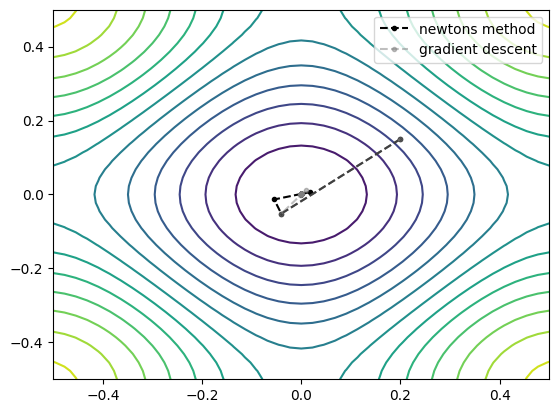

In [8]:
# run this to get plots
run_examples_dfp()

## Task 6: BFGS method

Implement the BFGS method using the above provided backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `bfgs_path` should return a list of vectors on the path to the minimum.

In [9]:
def bfgs_path(x0, f, g, max_iter=100):
    tol = 1e-8
    n = len(x0)
    Hk = np.eye(n)
    x = x0
    grad = g(x)
    path = [x]

    for _ in range(max_iter):
        direction = -Hk.dot(grad)
        step_size = backtracking_line_search(x, direction, f, g)
        x_new = x + step_size * direction

        sk = x_new - x
        grad_new = g(x_new)
        yk = grad_new - grad

        sk_yk = sk.dot(yk)
        if sk_yk > tol:
            Hkyk = Hk.dot(yk)
            Hk += ((sk_yk + Hkyk.dot(yk)) / sk_yk**2) * np.outer(sk, sk)
            Hk -= (np.outer(Hkyk, sk) + np.outer(sk, Hkyk)) / sk_yk

        x, grad = x_new, grad_new
        path.append(x)

    return path

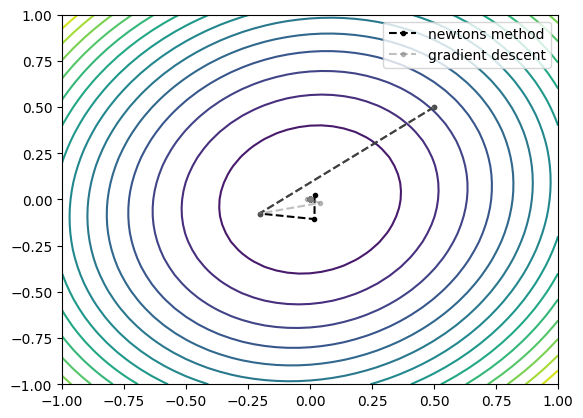

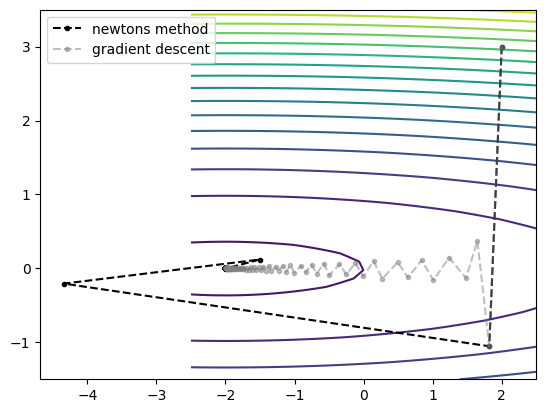

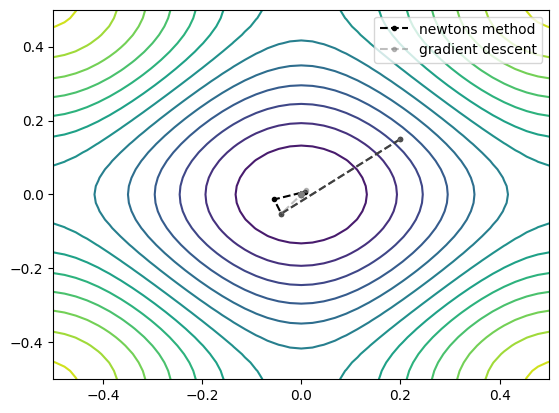

In [10]:
# run this to get plots
run_examples_bfgs()

## Task 7: Error plots

Then compare and plot the error over time for the five methods on the following tasks.
Implementations of the prior methods are given in the Utils section.

### Simple quadratic function

In [18]:
def f(x):
    return x[0] ** 2 + 30 * x[1] ** 2 + 4 * x[0]


def g(x):
    return np.array([2 * x[0] + 4, 60 * x[1]])


def h(x):
    return np.array([[2.0, 0], [0, 60]])

def plot_optimization_paths(f, x_target, **paths):
    for method, path in paths.items():
        values = [f(x) for x in path]
        plt.semilogy(
            np.arange(len(path)),
            values - f(x_target),
            label=method
        )

    plt.legend()
    plt.show()



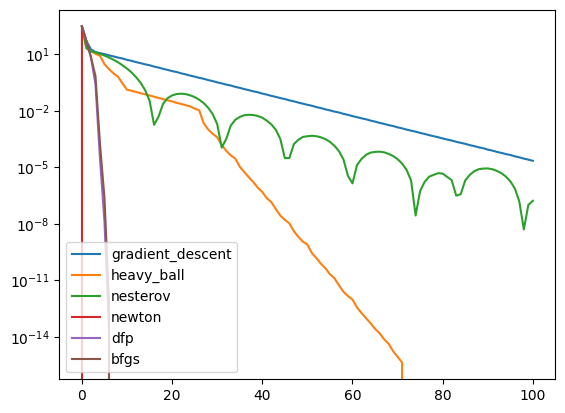

In [20]:
x_start = np.array([2.0, 3.0])
x_target = np.array([-2.0, 0.0])

heavy_ball = heavy_ball_path(x_start, f, g)
nesterov = nag_path(x_start, f, g)
gradient_descent = gradient_descent_path(x_start, f, g)
newton = newtons_method_path(x_start, f, g, h)
dfp = dfp_path(x_start, f, g)
bfgs = bfgs_path(x_start, f, g)

plot_optimization_paths(
    f,
    x_target,
    gradient_descent=gradient_descent,
    heavy_ball=heavy_ball,
    nesterov=nesterov,
    newton=newton,
    dfp=dfp,
    bfgs=bfgs
)


### Linear regression

In [22]:
from sklearn.datasets import make_regression


def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)


def g(w):
    return 2 * X.T @ (X @ w - y) / len(X)


def h(w):
    return 2 * X.T @ X / len(X)


X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)
x0 = np.zeros(100)

x_star = np.linalg.lstsq(X, y, rcond=None)[0]

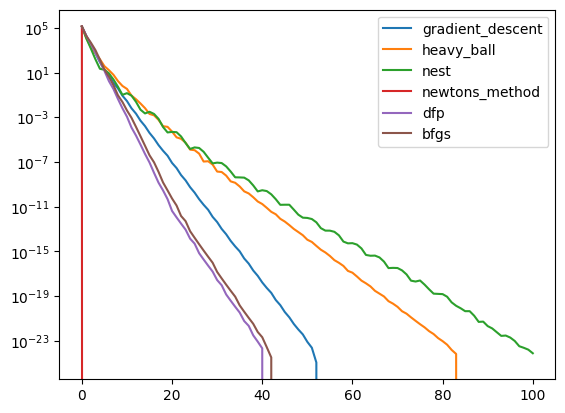

In [23]:
heavy_ball = heavy_ball_path(x0, f, g)
nest = nag_path(x0, f, g)
gradient_descent = gradient_descent_path(x0, f, g)
newtons_method = newtons_method_path(x0, f, g, h, max_iter=2)
dfp = dfp_path(x0, f, g)
bfgs = bfgs_path(x0, f, g)

plot_optimization_paths(
    f,
    x_star,
    gradient_descent=gradient_descent,
    heavy_ball=heavy_ball,
    nest=nest,
    newtons_method=newtons_method,
    dfp=dfp,
    bfgs=bfgs
)

### Logistic regression


In [24]:
from sklearn.datasets import make_classification
from scipy.optimize import minimize


def f(w):
    return np.log(1.0 + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w) ** 2


def g(w):
    sig = np.exp(-y * X.dot(w))
    return 2 * w - X.T.dot(sig * y / (sig + 1.0)) / X.shape[0]


def h(w):
    X_rows, w_rows = X.shape
    t_0 = np.exp(-(y * (X).dot(w)))
    t_1 = t_0 * y
    t_2 = np.ones(X_rows) + t_0
    hess = (2 * np.eye(w_rows, w_rows)) - 1 / X_rows * (
        (((((t_1 * t_0) * y) / (t_2 * t_2))[:, np.newaxis] * X).T).dot(X)
        - (((((y * t_0) * y) / t_2)[:, np.newaxis] * X).T).dot(X)
    )
    return hess


X, y = make_classification(
    1000,
    80,
    n_informative=40,
    #                               n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0,
)

x0 = np.zeros(80)
x_star = minimize(f, x0, jac=g).x

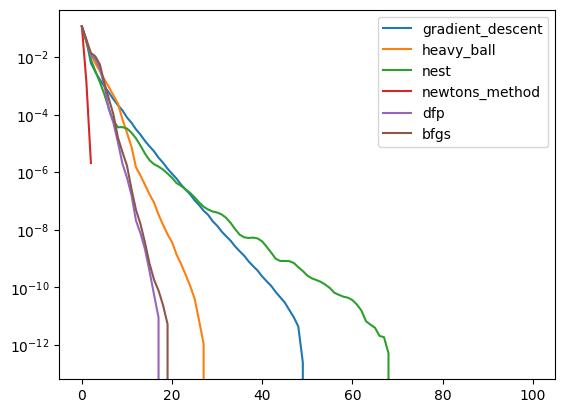

In [25]:
heavy_ball = heavy_ball_path(x0, f, g)
nest = nag_path(x0, f, g)
gradient_descent = gradient_descent_path(x0, f, g)
newtons_method = newtons_method_path(x0, f, g, h, max_iter=2)
dfp = dfp_path(x0, f, g)
bfgs = bfgs_path(x0, f, g)

plot_optimization_paths(
    f,
    x_star,
    gradient_descent=gradient_descent,
    heavy_ball=heavy_ball,
    nest=nest,
    newtons_method=newtons_method,
    dfp=dfp,
    bfgs=bfgs
)